In [41]:
import os
import sys
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import robustness
from robustness import NETWORKS_DIR
from robustness.mpl_settings_v3 import *
from robustness.plot_auxiliary import *
from robustness.planar import create_proximity_graph
from robustness.auxiliary import get_base_network_name, getLinearReg, powerlaw

%matplotlib inline

net_type = 'DT'
param = 'param'

net_dir = NETWORKS_DIR

8192
16384
32768
65536
131072


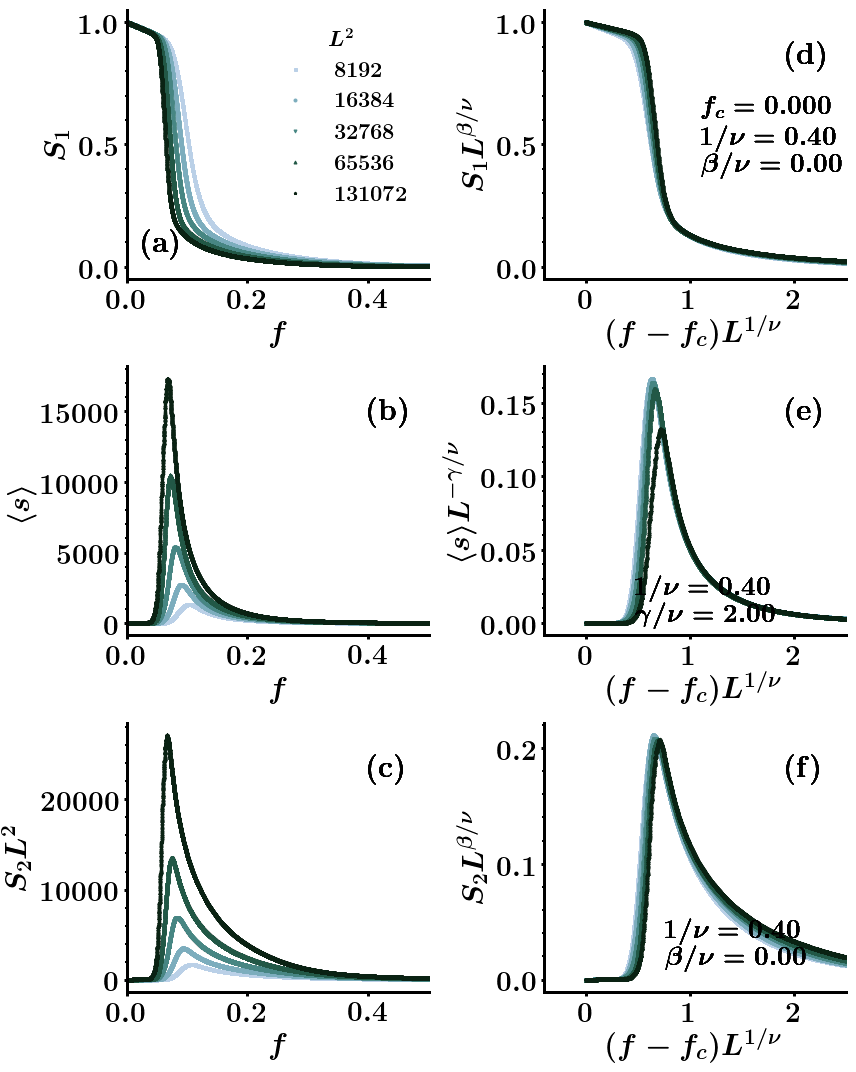

In [3]:
#fc = 0.04
fc = 0.0
one_over_nu = 0.4
nu = 1 / one_over_nu

attack = 'Btw'
sizes = [8192, 16384, 32768, 65536, 131072]

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=100)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colormap = sns.cubehelix_palette(
    len(L_values), start=2, rot=0.3, light=0.8, dark=0.1
)

ncols = 2
nrows = 3
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)
    
for ax in axes[:,0]:
    ax.set_xlim(0, 0.5)
    ax.set_xlabel(r'$f$')
for ax in axes[:,1]:
    ax.set_xlim(-0.4, 2.5)
    ax.set_xlabel(r'$(f-f_c) L^{1/\nu}$')
    
ax = axes[0,0]
ax.set_ylabel(r'$S_1$')
ax = axes[1,0]
ax.set_ylabel(r'$\langle s\rangle$')
ax = axes[2,0]
ax.set_ylabel(r'$S_2L^2$')

ax = axes[0,1]
#ax.set_ylim(0.1, 1.05)
ax.set_ylabel(r'$S_1 L^{\beta/\nu}$')
ax = axes[1,1]
ax.set_ylabel(r'$\langle s\rangle L^{-\gamma/\nu}$')
ax = axes[2,1]
ax.set_ylabel(r'$S_2 L^{\beta/\nu}$')

for i, N in enumerate(N_values):
    print(N)
    df = dfs[N]
    L = np.sqrt(N)

    ax = axes[0,0]
    ax.text(0.05, 0.1, letters[0], transform=ax.transAxes, fontsize=30)
    ax.plot(df.f, df.Sgcc, linestyle='', marker=markers[i], markersize=3,
            label=r'${{{}}}$'.format(N), color=colormap[i])
    
    ax = axes[0,1]
    ax.text(0.8, 0.8, letters[3], transform=ax.transAxes, fontsize=30)
    beta = 0
    beta_over_nu = beta / nu
    ax.plot((df.f-fc)*L**one_over_nu, df.Sgcc*N**(beta_over_nu), linestyle='', marker=markers[i], markersize=3,
        label=r'${{{}}}$'.format(N), color=colormap[i])
    ax.text(0.52, 0.6, r'$f_c = {{{:.3f}}}$'.format(fc), 
        transform=ax.transAxes, fontsize=26)
    ax.text(0.52, 0.5, r'$1/\nu = {{{:.2f}}}$'.format(one_over_nu), 
            transform=ax.transAxes, fontsize=26)
    ax.text(0.52, 0.4, r'$\beta/\nu = {{{:.2f}}}$'.format(beta_over_nu), 
            transform=ax.transAxes, fontsize=26)
    
    
    ax = axes[1,0]
    ax.text(0.8, 0.8, letters[1], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.meanS, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    ax = axes[1,1]
    ax.text(0.8, 0.8, letters[4], transform=ax.transAxes, fontsize=30)
    gamma_over_nu = 2.0
    gamma = gamma_over_nu * nu
    ax.plot(
        (df.f-fc)*L**one_over_nu, df.meanS*L**(-gamma_over_nu), linestyle='', 
        marker=markers[i], markersize=3, color=colormap[i]
    )
    ax.text(0.3, 0.15, r'$1/\nu = {{{:.2f}}}$'.format(one_over_nu), 
        transform=ax.transAxes, fontsize=26)
    ax.text(0.3, 0.05, r'$\gamma/\nu = {{{:.2f}}}$'.format(gamma_over_nu), 
            transform=ax.transAxes, fontsize=26)
    
    
    ax = axes[2,0]
    ax.text(0.8, 0.8, letters[2], transform=ax.transAxes, fontsize=30)
    ax.plot(
        df.f, df.Nsec, linestyle='', marker=markers[i], markersize=3, color=colormap[i]
    )
    ax = axes[2,1]
    ax.text(0.8, 0.8, letters[5], transform=ax.transAxes, fontsize=30)
    beta = 0.0
    beta_over_nu = beta / nu
    ax.plot(
        (df.f-fc)*L**one_over_nu, df.Nsec*L**(beta_over_nu-2), linestyle='', 
        marker=markers[i], markersize=3, color=colormap[i]
    )
    ax.text(0.4, 0.2, r'$1/\nu = {{{:.2f}}}$'.format(one_over_nu), 
        transform=ax.transAxes, fontsize=26)
    ax.text(0.4, 0.1, r'$\beta/\nu = {{{:.2f}}}$'.format(beta_over_nu), 
            transform=ax.transAxes, fontsize=26)


legend = axes[0,0].legend(fontsize=22, frameon=False)
legend.set_title(r'$L^2$', prop={'size':22})

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'collapse_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

In [119]:
net_type = 'DT'
measures = ['meanS', 'Nsec']
attacks = ['Btw']

sizes = [8192, 16384, 32768, 65536, 131072]

print('attack\t          beta/nu     beta gamma/nu    gamma        2  delta_2      tau delta_tau     N_max')

data = {}
for k, attack in enumerate(attacks):
    
    data[attack] = {}
    
    dfs = {}
    for N in sizes:
        try:
            dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=100)
        except FileNotFoundError:
            continue
    N_values = np.array(list(dfs.keys()))
    L_values = np.sqrt(N_values)
        
    for i, measure in enumerate(measures):
        
        measure_values = get_critical_measures(dfs, measure, fc='peak')
        Y_pred, slope, y_err = getLinearReg(L_values, measure_values)
        
        if measure == 'Nsec':
            beta_over_nu = 2 - slope
            delta_beta = y_err
        elif measure == 'meanS':
            gamma_over_nu = slope
            delta_gamma = y_err       
            
        data[attack][measure] = [L_values, measure_values, Y_pred, slope, y_err]
            
    err_one = 2*delta_beta + delta_gamma
    tau = 2+beta_over_nu/(beta_over_nu+gamma_over_nu)
    delta_tau = np.fabs(delta_beta)/beta_over_nu +\
               (np.fabs(delta_gamma)+np.fabs(delta_beta))*(beta_over_nu/(beta_over_nu + gamma_over_nu))
    
    nu = 4/3
    print(
        '{:10}\t{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:9.4f}{:10.4f}{:10.0f}'.format(
        attack, beta_over_nu, beta_over_nu*nu, gamma_over_nu, gamma_over_nu*nu,
        2*beta_over_nu+gamma_over_nu, err_one, tau, delta_tau, np.max(N_values)
        )
    )

attack	          beta/nu     beta gamma/nu    gamma        2  delta_2      tau delta_tau     N_max
Btw       	   0.0079   0.0106   1.8559   2.4746   1.8718   0.0781   2.0042    1.1199    131072


In [113]:
marker_dict = {'meanS': 'o', 'Nsec': 's'}
color_dict = {'meanS': colors[0], 'Nsec': colors[1]}
linestyle_dict = {'meanS': '--', 'Nsec': '-.'}
label_dict = {'meanS': r'$\langle s \rangle$', 'Nsec': r'$S_2 N$'}
line_colors = {'meanS': 'k', 'Nsec': 'grey'}

meanS [0.1026611328125, 0.09088134765625, 0.080413818359375, 0.0717315673828125, 0.0675048828125]
Nsec [0.1077880859375, 0.09326171875, 0.08306884765625, 0.0743560791015625, 0.06746673583984375]


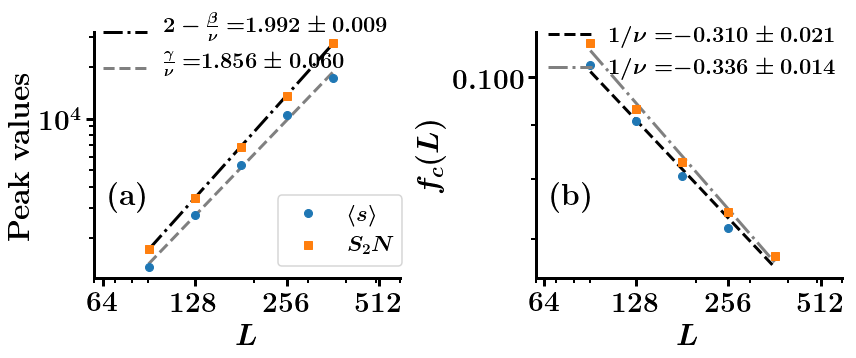

In [124]:
attack = 'Btw'
measures = ['meanS', 'Nsec']

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

for ax in axes:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(60, 600)
    ax.set_xticks([64, 128, 256, 512])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0]

ax.text(0.05, 0.3, letters[0], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$\mathrm{Peak\;values}$')

for i, measure in enumerate(measures):

    L_values, measure_values, Y_pred, slope, y_err = data[attack][measure]    

    if measure == 'meanS':
        label = r'$\frac{\gamma}{\nu} = $' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
        label1 = label
        line1, = ax.plot(L_values, Y_pred, '--', color='grey', label=label)

    elif measure == 'Nsec':
        label = r'$2 - \frac{\beta}{\nu} = $' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
        label2 = label
        line2, = ax.plot(L_values, Y_pred, '-.', color='k', label=label)            

    markers1, = ax.plot(
        L_values, measure_values, marker_dict[measure], 
        color=color_dict[measure], markersize=8, 
        label=label_dict[measure]
    )

handles, labels = ax.get_legend_handles_labels()
## Markers
order = [1, 3]
legend1 = ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.6, 0.05))

ax.add_artist(legend1)
## Lines
order = [2, 0]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.0, 0.77), frameon=False)


sizes = [8192, 16384, 32768, 65536, 131072]

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=100)
    except FileNotFoundError:
        continue
        
N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

ax = axes[1]
ax.text(0.05, 0.3, letters[1], transform=ax.transAxes, fontsize=30)
ax.set_ylabel(r'$f_c(L)$')

fc = 0.0
for i, measure in enumerate(measures):
        
    X = L_values
    Y, _ = getPeaks(dfs, measure)
    print(measure, Y)
    Y = np.array(Y) - fc
    
    Y_pred, slope, y_err = getLinearReg(X, Y)
    
    c = Y[0] / X[0]**slope
    label = r'$1/\nu = $' + r'${{{:.3f}}}\pm{{{:.3f}}}$'.format(slope, y_err)
    ax.plot(X, Y_pred, linestyle_dict[measure], color=line_colors[measure], label=label)
    ax.plot(X, Y, marker_dict[measure], markersize=8, label=measures_dict[measure])
    
handles, labels = ax.get_legend_handles_labels()

## Lines
order = [0, 2]
ax.legend([handles[idx] for idx in order], [labels[idx] for idx in order],
          fontsize=22, loc=(0.01, 0.77), frameon=False)

#ax.set_ylim(0.02, 0.2)
#ax.set_yticks([0.02, 0.1, 0.2])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'beta_gamma_nu_scaling_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

/media/nahuel/datos/d/anaconda3/envs/networks3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in greater
No handles with labels found to put in legend.


Btw                 0.00010 +- 0.00000  0.000000


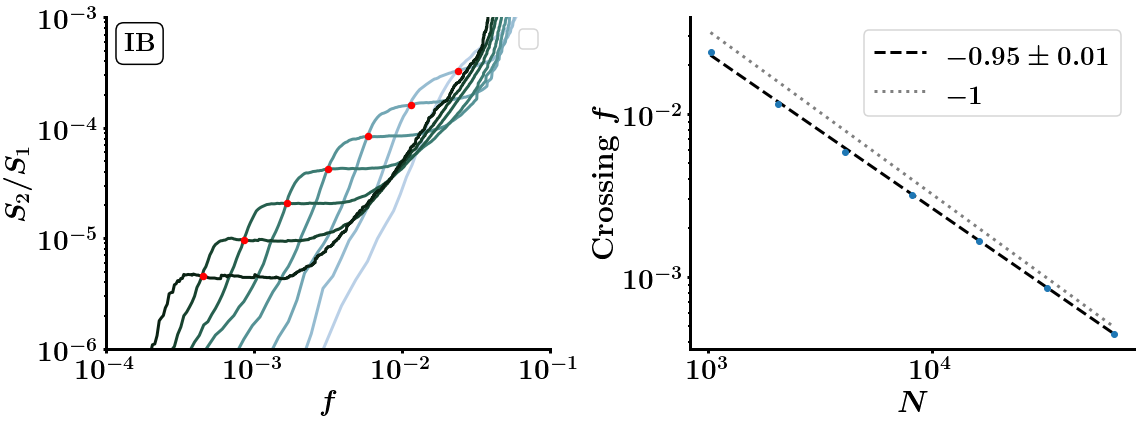

In [225]:
attack = 'Btw'
sizes = [1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072]  

dfs = {}
for N in sizes:
    try:
        dfs[N] = load_dataframe(net_type, N, param, attack, min_nseeds=100)
    except FileNotFoundError:
        print(N)
        continue

N_values = np.sort(list(dfs.keys()))
L_values = np.sqrt(N_values)

colors = sns.cubehelix_palette(
    len(N_values), start=2, rot=0.3, 
    light=0.8, dark=0.1
)

MIN = 1e-6
MAX = 1e-3
        
S2_over_S1 = {}
for N in N_values:
    df = dfs[N]        
    S1 = df.Sgcc
    S2 = df.Nsec / N
   
    S2_over_S1[N] = S2/S1
    
    
    mask = (S2_over_S1[N] < MIN) | (S2_over_S1[N] > MAX)
    S2_over_S1[N][mask] = np.NaN
    
cross_values = []
for N in sizes[:-1]:
    Na = N
    Nb = 2*N
    
    x = dfs[Nb].f.values
    
    xp = dfs[Na].f.values
    fp = S2_over_S1[Na]
    Na_values = np.interp(x, xp, fp)
    
    xp = dfs[Nb].f.values
    fp = S2_over_S1[Nb]
    Nb_values = np.interp(x, xp, fp)
    
    diff = Na_values - Nb_values
    #diff = S2_over_S1[Na].values - S2_over_S1[Nb].values

    argmax = np.argmax(diff>0)    
    cross_values.append((argmax/Nb, S2_over_S1[Nb][argmax]))
    
cross_values = np.array(cross_values)

X = sizes[:-1]
Y = cross_values[:,0]

Y_pred, slope, y_err = getLinearReg(X, Y)
c = Y[-1] / X[-1]**slope
Y_pred = powerlaw(X, slope, c)

fmin = 1e-4
fmax = 1e-1
ymin = 1e-6
ymax = 1e-3       

mean_fc, std_fc = compute_fc_v2(dfs, fmin, fmax, only_next=False, verbose=False)
print('{:20}{:.5f} +- {:.5f}{:10f}'.format(attack, mean_fc, std_fc, std_fc/mean_fc))

ncols = 2
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 6*nrows), ncols=ncols, nrows=nrows)

ax = axes[0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(fmin, fmax)
ax.set_ylim(ymin, ymax)

ax.set_ylabel(r'$S_2/S_1$', fontsize=28)
ax.set_xlabel(r'$f$', fontsize=28)


for i, N in enumerate(N_values):

    df = dfs[N]
    S1_over_S2 = N * df.Sgcc / df.Nsec
    S2_over_S1 = df.Nsec / (N * df.Sgcc)
    ax.plot(
        df.f[1:], S2_over_S1[1:], '-',
        color=colors[i])
    if N != N_values[-1]:
        ax.scatter(*cross_values[i], color='red', zorder=100)
    
bbox = {'boxstyle': 'round', 'fc': 'None'}
ax.text(0.04, 0.9, attack_dict[attack], fontsize=26, transform=ax.transAxes, bbox=bbox, 
        horizontalalignment='left')
ax.legend(loc='best', fontsize=24)


ax = axes[1]

label = r'${{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
ax.plot(X, Y_pred, '--', color='k', label=label)

label = r'$-1$'
ax.plot(X, powerlaw(X, -1., 2*c), ':', color='grey', label=label)
ax.plot(X, Y, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$N$')
ax.set_ylabel(r'$\mathrm{Crossing}\; f$')
ax.legend()


sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'crossing_method_B' + net_type)
plt.savefig(fig_name + '.png', transparent=False)
plt.savefig(fig_name + '.pdf')

plt.show()

In [122]:
attack = 'Btw'

sizes = np.array([1024, 2048, 4096, 8192, 16384, 32768, 65536, 131072])
all_mean_values = []
all_std_values = []
nseeds_values = []
fluctuations = {}
for i, N in enumerate(sizes):
    try:
        delta_values, nseeds = load_delta(net_type, N, param, attack, min_nseeds=100, return_nseeds=True)
    except FileNotFoundError:
        print(N)
        raise
        
    nseeds_values.append(nseeds)
    
    delta_values[:,2] = delta_values[:,2]*N
    mean_values = delta_values.mean(axis=0)
    std_values = delta_values.std(axis=0)
    
    all_mean_values.append(mean_values)
    all_std_values.append(std_values)
    
    fluctuations[N] = delta_values - mean_values
    
all_mean_values = np.array(all_mean_values)
all_std_values = np.array(all_std_values)
nseeds_values = np.array(nseeds_values)

rc_values = all_mean_values[:,0]
delta_values = all_mean_values[:,1]

print(sizes, rc_values)

[  1024   2048   4096   8192  16384  32768  65536 131072] [0.14868398 0.12307358 0.10567444 0.09316479 0.0833751  0.07524434
 0.06785184 0.06096718]


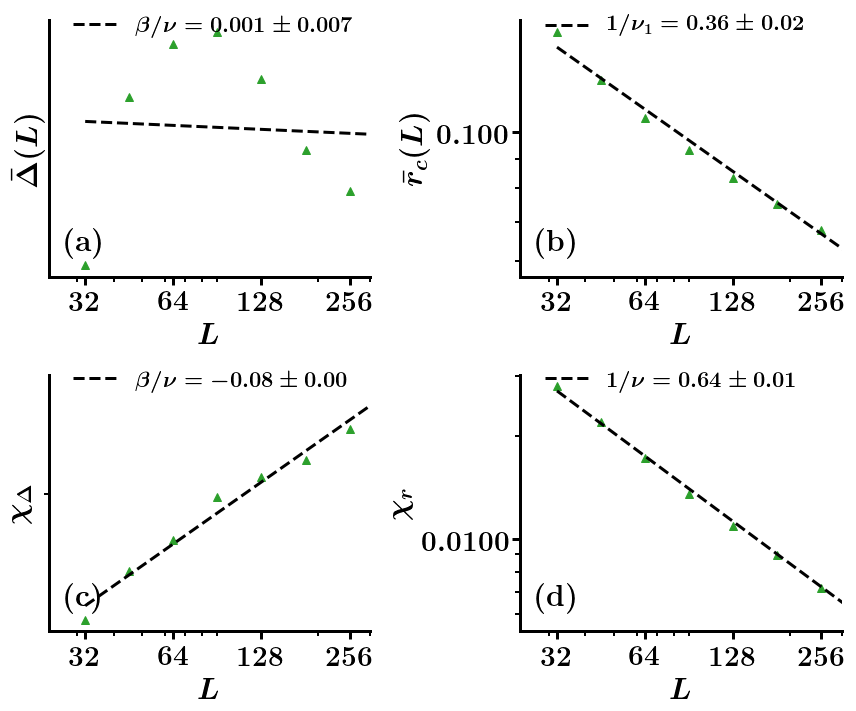

In [123]:
attack = 'BtwU'
measures = ['meanS', 'Nsec']
X = np.sqrt(sizes)

ncols = 2
nrows = 2
fig, axes = plt.subplots(figsize=(6*ncols, 5*nrows), ncols=ncols, nrows=nrows)

for ax in axes.flatten():
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(24, 300)
    ax.set_xticks([32, 64, 128, 256])
    ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
    ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    ax.set_xlabel(r'$L$')
    
ax = axes[0,0]
ax.text(0.05, 0.1, letters[0], transform=ax.transAxes, fontsize=30)
#ax.set_ylim([0.3, 0.5])
#ax.set_yticks([0.39, 0.40, 0.41, 0.42])
#ax.set_yticks([0.3, 0.40, 0.5])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\bar{\Delta}(L)$')
Y = all_mean_values[:,1]
Y_pred, slope, y_err = getLinearReg(X, Y)
Y_err = np.sqrt(all_std_values[:,1]/nseeds_values)
ax.plot(X, Y, '^', color='C2', markersize=8)
#ax.errorbar(X, Y, Y_err, marker='^', color='C2', markersize=8)
ax.plot(X, Y_pred, '--', color='k', label=r'$\beta/\nu={{{:.3f}}}\pm{{{:.3f}}}$'.format(-slope, y_err))
ax.legend(fontsize=22, loc=(0.05, 0.9), frameon=False)

ax = axes[0,1]
ax.text(0.05, 0.1, letters[1], transform=ax.transAxes, fontsize=30)
#ax.set_ylim([0.018, 0.085])
#ax.set_yticks([0.02, 0.04, 0.06, 0.08])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

ax.set_ylabel(r'$\bar{r}_c(L)$')
Y = all_mean_values[:,0]
Y_pred, slope, y_err = getLinearReg(X, Y)
ax.plot(X, Y, '^', color='C2', markersize=8)
ax.plot(X, Y_pred, '--', color='k', label=r'$1/\nu_1={{{:.2f}}}\pm{{{:.2f}}}$'.format(-slope, y_err))
ax.legend(fontsize=22, loc=(0.05, 0.9), frameon=False)

ax = axes[1,0]
ax.text(0.05, 0.1, letters[2], transform=ax.transAxes, fontsize=30)
#ax.set_ylim([0.04, 0.072])
#ax.set_yticks([0.04, 0.05, 0.06, 0.07])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\chi_{\Delta}$')
Y = all_std_values[:,1]
Y_pred, slope, y_err = getLinearReg(X, Y)
beta_over_nu = -slope
ax.plot(X, Y, '^', color='C2', markersize=8)
ax.plot(X, Y_pred, '--', color='k', label=r'$\beta/\nu={{{:.2f}}}\pm{{{:.2f}}}$'.format(-slope, y_err))
ax.legend(fontsize=22, loc=(0.05, 0.9), frameon=False)


ax = axes[1,1]
ax.text(0.05, 0.1, letters[3], transform=ax.transAxes, fontsize=30)
#ax.set_ylim([0.002, 0.02])
#ax.set_yticks([0.002, 0.01, 0.02])
ax.get_yaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_ylabel(r'$\chi_{r}$')
Y = all_std_values[:,0]
Y_pred, slope, y_err = getLinearReg(X, Y)
ax.plot(X, Y, '^', color='C2', markersize=8)
ax.plot(X, Y_pred, '--', color='k', label=r'$1/\nu={{{:.2f}}}\pm{{{:.2f}}}$'.format(-slope, y_err))
ax.legend(fontsize=22, loc=(0.05, 0.9), frameon=False)

sns.despine()
plt.tight_layout()
fig_name = os.path.join(fig_dir, 'gap_exp_scaling_B_{}'.format(net_type))
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')

plt.show()

{16384: 1000, 32768: 1000, 65536: 1000}


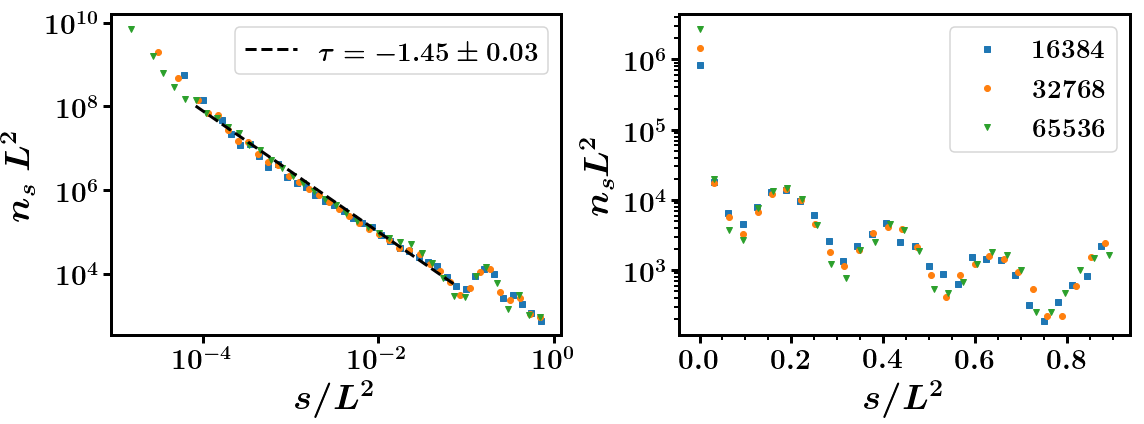

In [101]:
def get_histo(comp_sizes, nbins=None, log=True, density=True):
    
    if nbins is None:
        nbins = 20
    
    mask = comp_sizes > 0
    comp_sizes = comp_sizes[mask]     
    min_s = np.min(comp_sizes)
    max_s = np.max(comp_sizes)
    if log:
        bins = np.logspace(np.log10(min_s), np.log10(max_s), nbins)
    else:
        bins = np.linspace(min_s, max_s+1, nbins)
    freq, bin_edges = np.histogram(comp_sizes, bins=bins, density=density)
    freq_norm = freq.astype('float')
    freq_norm[freq_norm==0] = np.NaN
    
    freq_norm = freq_norm / np.diff(bin_edges)
    
    mask = ~np.isnan(freq_norm)
    X = bins[:-1]
    X = X[mask]
    Y = freq_norm[mask]

    return X, Y

attack = 'Btw'
sizes = [16384, 32768, 65536]
#sizes = [65536]
gcc = True

f_values_dict = {
    65536: ['0.06809', '0.07231', '0.07579'],
    32768: ['0.07524', '0.08041', '0.08307'],
    16384: ['0.08338', '0.09088', '0.09326'],
    8192: ["_", "0.10266", "_"],
    4096: ["_", "_", "_"],
    2048: ["_", "_", "_"],
    1024: ["_", "_", "_"]
}

all_comp_sizes = {}
nseeds_values = {}

for N in sizes:
    f_value = f_values_dict[N][1]
    
    net_dir_name = '../networks/DT/DT_param'.format(param)
    base_net_name = 'DT_param_N{}'.format(N)
    base_net_dir_name = os.path.join(net_dir_name, base_net_name)
    if gcc:
        comp_sizes_file = 'comp_sizes_gcc_{}_f{}.txt'.format(attack, f_value)
        seeds_file = 'comp_sizes_gcc_{}_f{}_seeds.txt'.format(attack, f_value)
    else:
        comp_sizes_file = 'comp_sizes_{}_f{}.txt'.format(attack, f_value)
        seeds_file = 'comp_sizes_{}_f{}_seeds.txt'.format(attack, f_value)
    full_comp_sizes_file = os.path.join(base_net_dir_name, comp_sizes_file)
    full_seeds_file = os.path.join(base_net_dir_name, seeds_file)
    comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
    nseeds = len(np.loadtxt(full_seeds_file, dtype=int))

    nseeds_values[N] = nseeds
    all_comp_sizes[N] = comp_sizes

print(nseeds_values)

ncols = 2
fig, axes = plt.subplots(figsize=(8*ncols,6), ncols=ncols)

for ax in axes:
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    
ax = axes[0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$s/L^2$', fontsize=36)
ax.set_ylabel(r'$n_s\;L^2$', fontsize=36)    

for i, N in enumerate(sizes):

    comp_sizes = all_comp_sizes[N]
    comp_sizes = comp_sizes[comp_sizes>0]
    nbins = 40   
    X, Y = get_histo(comp_sizes, nbins=nbins, log=True, density=False)
    
    X = X / N
    Y = Y*N
    
    ax.plot(
        X, Y, marker=markers[i], linestyle=''
    )
    if N == sizes[-1]:
        Y_pred, slope, y_err = getLinearReg(X[5:-8], Y[5:-8])
        label = r'$\tau = {{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
        ax.plot(X[5:-8], Y_pred, '--', color='k', label=label)
ax.legend()      

ax = axes[1]
ax.set_yscale('log')
ax.set_xlabel(r'$s/L^2$', fontsize=36)
ax.set_ylabel(r'$n_s L^2$', fontsize=36)    

for i, N in enumerate(sizes):

    comp_sizes = all_comp_sizes[N]
    comp_sizes = comp_sizes[comp_sizes>0]
    nbins = 30   
    X, Y = get_histo(comp_sizes, nbins=nbins, log=False, density=False)
    
    X = X / N
    Y = Y * N
    
    ax.plot(
        X, Y, marker=markers[i], linestyle='', label=r'${{{}}}$'.format(N)
    )
ax.legend()      

plt.tight_layout()
if gcc:
    base_name = 'ns_scaled_B_gcc_{}'.format(net_type)
else:
    base_name = 'ns_scaled_B_{}'.format(net_type)
    
fig_name = os.path.join(fig_dir, base_name)
plt.savefig(fig_name + '.png')
plt.savefig(fig_name + '.pdf')
plt.show()

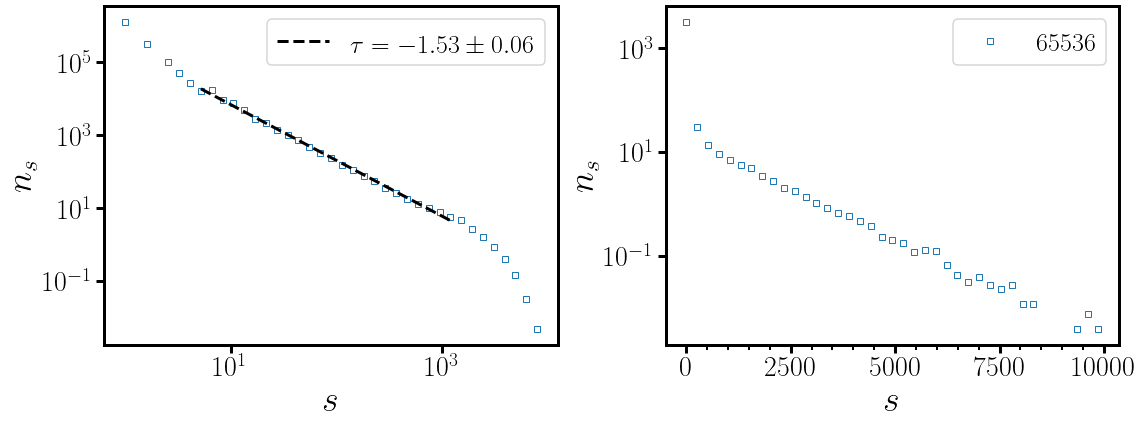

In [46]:
def get_histo(comp_sizes, nbins=None, log=True, density=True):
    
    if nbins is None:
        nbins = 20
    
    mask = comp_sizes > 0
    comp_sizes = comp_sizes[mask]     
    min_s = np.min(comp_sizes)
    max_s = np.max(comp_sizes)
    if log:
        bins = np.logspace(np.log10(min_s), np.log10(max_s), nbins)
    else:
        bins = np.linspace(min_s, max_s+1, nbins)
    freq, bin_edges = np.histogram(comp_sizes, bins=bins, density=density)
    freq_norm = freq.astype('float')
    freq_norm[freq_norm==0] = np.NaN
    
    freq_norm = freq_norm / np.diff(bin_edges)
    
    mask = ~np.isnan(freq_norm)
    X = bins[:-1]
    X = X[mask]
    Y = freq_norm[mask]

    return X, Y

attack = 'Btw'
#sizes = [16384, 32768, 65536]
sizes = [65536]

f_values_dict = {
    65536: ['0.06809', '0.07231', '0.07579'],
    32768: ['0.07524', '0.08041', '0.08307'],
    16384: ['0.08338', '0.09088', '0.09326'],
    8192: ["_", "0.10266", "_"],
    4096: ["_", "_", "_"],
    2048: ["_", "_", "_"],
    1024: ["_", "_", "_"]
}

drop = 4

all_comp_sizes = {}
nseeds_values = {}

for N in sizes:
    f_value = f_values_dict[N][1]
    
    net_dir_name = Path('../networks/DT/DT_param'.format(param))
    base_net_name = f'DT_param_N{N}'
    base_net_dir_name = net_dir_name / base_net_name    
    comp_sizes_file = f'comp_sizes_{attack}_f{f_value}_drop{drop}.txt'
    seeds_file = f'comp_sizes_{attack}_f{f_value}_drop{drop}_seeds.txt'
    full_comp_sizes_file = base_net_dir_name / comp_sizes_file
    full_seeds_file = base_net_dir_name / seeds_file
    comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
    nseeds = len(np.loadtxt(full_seeds_file, dtype=int))
    nseeds_values[N] = nseeds
    all_comp_sizes[N] = comp_sizes
    

ncols = 2
fig, axes = plt.subplots(figsize=(8*ncols,6), ncols=ncols)

for ax in axes:
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    
ax = axes[0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$s$', fontsize=36)
ax.set_ylabel(r'$n_s$', fontsize=36)    

for i, N in enumerate(sizes):
    comp_sizes = all_comp_sizes[N]
    comp_sizes = comp_sizes[comp_sizes>0]
    nbins = 40   
    X, Y = get_histo(comp_sizes, nbins=nbins, log=True, density=False)
    ax.plot(
        X, Y, marker=markers[i], linestyle='', fillstyle='none'
    )
    if N == sizes[-1]:
        Y_pred, slope, y_err = getLinearReg(X[5:-8], Y[5:-8])
        label = r'$\tau = {{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
        ax.plot(X[5:-8], Y_pred, '--', color='k', label=label)
ax.legend()      

ax = axes[1]
ax.set_yscale('log')
ax.set_xlabel(r'$s$', fontsize=36)
ax.set_ylabel(r'$n_s$', fontsize=36)    

for i, N in enumerate(sizes):
    comp_sizes = all_comp_sizes[N]
    comp_sizes = comp_sizes[comp_sizes>0]
    nbins = 40   
    X, Y = get_histo(comp_sizes, nbins=nbins, log=False, density=False)
    ax.plot(
        X, Y, marker=markers[i], fillstyle='none', linestyle='', label=r'${{{}}}$'.format(N)
    )
ax.legend()      
plt.tight_layout()
plt.show()

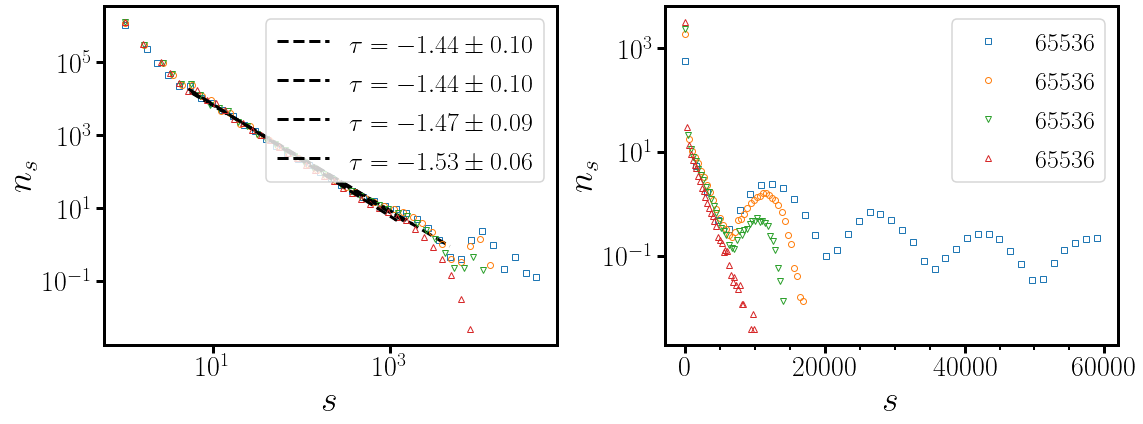

In [50]:
ncols = 2
fig, axes = plt.subplots(figsize=(8*ncols,6), ncols=ncols)

for ax in axes:
    ax.tick_params(which='minor', length=5)
    ax.tick_params(which='major', length=8)
    
ax = axes[0]
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$s$', fontsize=36)
ax.set_ylabel(r'$n_s$', fontsize=36)    

ax = axes[1]
ax.set_yscale('log')
ax.set_xlabel(r'$s$', fontsize=36)
ax.set_ylabel(r'$n_s$', fontsize=36)  

N = 65536
for i, drop in enumerate([0, 2, 3, 4]):

    f_value = f_values_dict[N][1]

    net_dir_name = Path('../networks/DT/DT_param'.format(param))
    base_net_name = f'DT_param_N{N}'
    base_net_dir_name = net_dir_name / base_net_name
    comp_sizes_file = f'comp_sizes_{attack}_f{f_value}_drop{drop}.txt'
    seeds_file = f'comp_sizes_{attack}_f{f_value}_drop{drop}_seeds.txt'
    full_comp_sizes_file = base_net_dir_name / comp_sizes_file
    full_seeds_file = base_net_dir_name / seeds_file
    comp_sizes = np.loadtxt(full_comp_sizes_file, dtype=int)
    nseeds = len(np.loadtxt(full_seeds_file, dtype=int))

    comp_sizes = comp_sizes[comp_sizes>0]

    ax = axes[0]
    nbins = 40   
    X, Y = get_histo(comp_sizes, nbins=nbins, log=True, density=False)
    ax.plot(
        X, Y, marker=markers[i], linestyle='', fillstyle='none'
    )
    Y_pred, slope, y_err = getLinearReg(X[5:-8], Y[5:-8])
    label = r'$\tau = {{{:.2f}}}\pm{{{:.2f}}}$'.format(slope, y_err)
    ax.plot(X[5:-8], Y_pred, '--', color='k', label=label)
    ax.legend()      
    
    ax = axes[1]
    nbins = 40   
    X, Y = get_histo(comp_sizes, nbins=nbins, log=False, density=False)
    ax.plot(
        X, Y, marker=markers[i], fillstyle='none', linestyle='', label=r'${{{}}}$'.format(N)
    )
ax.legend()      
plt.tight_layout()
plt.show()